## Question 1

### Computional graph, backpropagation, and chain rule for tanh

<img src="pic2.jpeg" width="600" height="400">

In [89]:
# load some libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt 

#ignore overflow error
np.seterr(over = 'ignore')

{'divide': 'warn', 'over': 'ignore', 'under': 'ignore', 'invalid': 'warn'}

## Question 2

### Adding activiation functions to a fully-connect feedforward neural network

In [80]:
class FeedforwardNeuralNetworkSGD:
    
    # input a vector [a, b, c, ...] with the number of nodes in each layer
    def __init__(self, layers, alpha = 0.1, batchSize = 32, activation_function = "sigmoid"):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # batch size
        self.batchSize = batchSize
        
        # activation function
        self.activation_function = activation_function
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        #initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1))
            
        #initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1]))
        
        #Initialize plotting arrays
        self.plot_losses = []
        self.plot_epochs = []
        self.plot_accuracies = []
        
    # define the sigmoid activation
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the sigmoid derivative (where z is the output of a sigmoid)
    def sigmoidDerivative(self, z):
        return z * (1 - z)
    
        #define the hyperbolic tangent activation
    def hyperbolicTangent(self, x):
        return np.tanh(x)
    
    #define the tanh derivative
    def hyperbolicTangentDerivative(self, x):
        return 1/(np.cosh(x))**2
    
    #define the ReLu activation
    def reLu(self, x):
        return np.maximum(0, x)
    
    #define the reLu derivative
    def reLuDerivative(self,x):
        x[x<=0] = 0.0
        x[x>0] = 1.0
        return x
        
    def activation(self, arg):
        if (self.activation_function == "sigmoid"):
            return self.sigmoid(arg)
        elif (self.activation_function == "tanh"):
            return self.hyperbolicTangent(arg)
        elif (self.activation_function == "relu"):
            return self.reLu(arg)
        
    def backpropogation(self, arg):
        if (self.activation_function == "sigmoid"):
            return self.sigmoidDerivative(arg)
        elif (self.activation_function == "tanh"):
            return self.hyperbolicTangentDerivative(arg)
        elif (self.activation_function == "relu"):
            return self.reLuDerivative(arg)
    
    # get a new mini-batch of data from the dataset
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            # yield returns a generator, which can continue where it left off on later callsof the function
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, epochs = 10000, update = 1000):
        
        # Initialize losses
        self.plot_losses = []
        self.plot_epochs = []
        self.plot_accuracies = []
        
        # add a column of ones to the end of X, but save the original X for accuracies
        inputX = X
        inputY = y
        y = to_categorical(y, 10)
        X = np.hstack((X, np.ones([X.shape[0],1])))

        for epoch in range(epochs):
            
            # randomize the examples
            p = np.arange(0, X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in range(len(self.W)):
                    
                    # feed through one layer and apply activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activation(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                D = [error * self.backpropogation(A[-1])]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.backpropogation(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update in each layer
                for layer in range(len(self.W)):
                    self.W[layer] -= self.alpha * A[layer].T.dot(D[layer])
                    
            # Store the accuracies and losses to plot later
            loss = self.computeLoss(X,y)
            self.plot_losses.append(loss)
            self.plot_epochs.append(epoch)
            predictedY = self.predict(inputX)
            predictedY = predictedY.argmax(axis=1)
            #inputY = inputY.argmax(axis=1)
            accuracy = accuracy_score(inputY, predictedY)
            self.plot_accuracies.append(accuracy)
                    
            # print an update
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)
                print('Epoch =', epoch + 1, '\t loss =', loss)
                              
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activation(np.dot(p, self.W[layer]))
            
        return p
    
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        loss = np.sum((predictions - y)**2) / 2.0
        
        return loss
    
    def plot_loss(self):
            %matplotlib inline 
            # plot() is used for plotting a line plot
            plt.plot(self.plot_epochs, self.plot_losses)
            # Adding title, xlabel and ylabel
            plt.title('Training Epoch Numbers vs. Training and Validation Loss') # Title of the plot
            plt.xlabel('Epochs') # X-Label
            plt.ylabel('Losses') # Y-Label
            # show() is used for displaying the plot
            plt.show()
            
    def plot_accuracy(self):
        %matplotlib inline 
        # plot() is used for plotting a line plot
        plt.plot(self.plot_epochs, self.plot_accuracies)
        # Adding title, xlabel and ylabel
        plt.title('Training Epoch Numbers vs. Training and Validation Accuracy') # Title of the plot
        plt.xlabel('Epochs') # X-Label
        plt.ylabel('Accuracy') # Y-Label
        # show() is used for displaying the plot
        plt.show()

## Question 3/4

### Train models using each of the activiation functions and outputing epoch vs. loss and epoch vs. accuracy graphs

Running Neural Network with Sigmoid Activation Function

Epoch = 50 	 loss = 2753.928694515108
Epoch = 100 	 loss = 2024.202067463536
Epoch = 150 	 loss = 1674.189085413613
Epoch = 200 	 loss = 1439.9352863489776
Epoch = 250 	 loss = 1282.6136918709897
Epoch = 300 	 loss = 1168.2087433029938
Epoch = 350 	 loss = 1086.4842400466252
Epoch = 400 	 loss = 1017.7963859850324
Epoch = 450 	 loss = 966.8881930740996
Epoch = 500 	 loss = 919.6208103010907
Epoch = 550 	 loss = 881.7430683870962
Epoch = 600 	 loss = 849.8641889427595
Epoch = 650 	 loss = 824.297303798401
Epoch = 700 	 loss = 802.0338347278501
Epoch = 750 	 loss = 780.9527225112364
Epoch = 800 	 loss = 764.6280638479162
Epoch = 850 	 loss = 749.1311994137185
Epoch = 900 	 loss = 734.2732130345655
Epoch = 950 	 loss = 721.3016600342517
Epoch = 1000 	 loss = 708.9953265119755
Training set accuracy
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5923
           1       1.00      0.99      0.99      6742
           2       0.98      0.

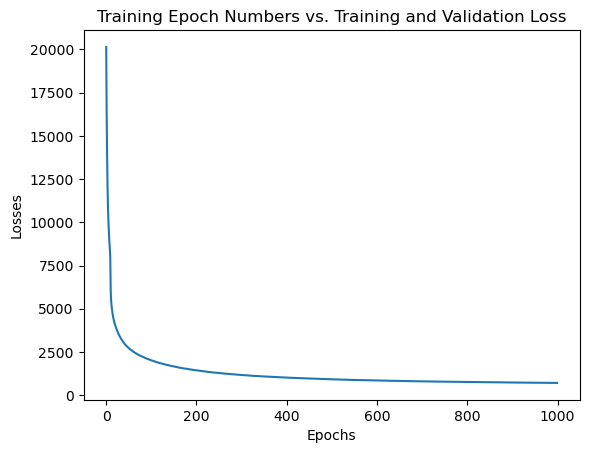

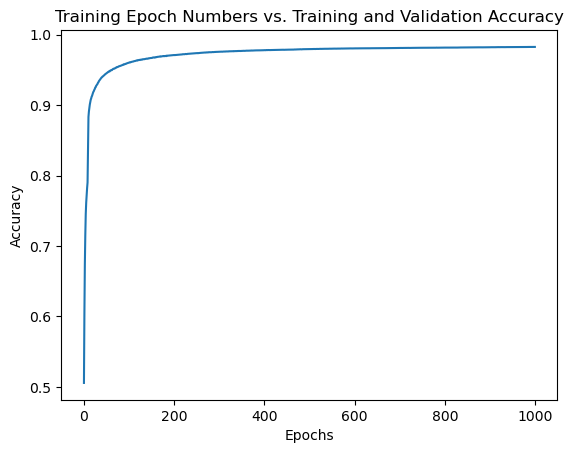

In [97]:
### CLASSIFY MNIST PICTURES

# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([784, 32, 16, 10], 0.01, 32, "sigmoid")
model.fit(trainX, trainY, 1000, 50)

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(testY, predictedY))
model.plot_loss()
model.plot_accuracy()

Running Neural Network with Tanh Activation Function

Epoch = 50 	 loss = 11578.968065945563
Epoch = 100 	 loss = 12201.05311916372
Epoch = 150 	 loss = 11591.300240349456
Epoch = 200 	 loss = 11784.335643638731
Epoch = 250 	 loss = 10969.706293869498
Epoch = 300 	 loss = 10596.538955022033
Epoch = 350 	 loss = 10585.311868000272
Epoch = 400 	 loss = 11047.351579144815
Epoch = 450 	 loss = 11239.706566986526
Epoch = 500 	 loss = 11537.632092488528
Epoch = 550 	 loss = 11807.76535287842
Epoch = 600 	 loss = 11976.96751576019
Epoch = 650 	 loss = 12211.300535942279
Epoch = 700 	 loss = 12472.697131480063
Epoch = 750 	 loss = 12703.268806705017
Epoch = 800 	 loss = 12962.2786797814
Epoch = 850 	 loss = 13170.441387389794
Epoch = 900 	 loss = 13196.936066670149
Epoch = 950 	 loss = 13069.111222572748
Epoch = 1000 	 loss = 13329.357242091279
Training set accuracy
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      5923
           1       0.82      0.95      0.88      6742
           2       0

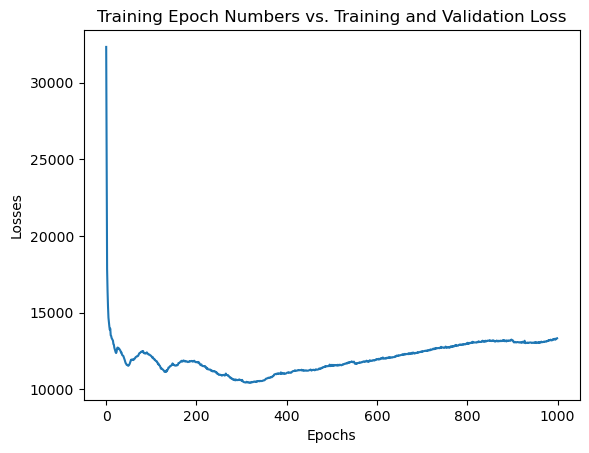

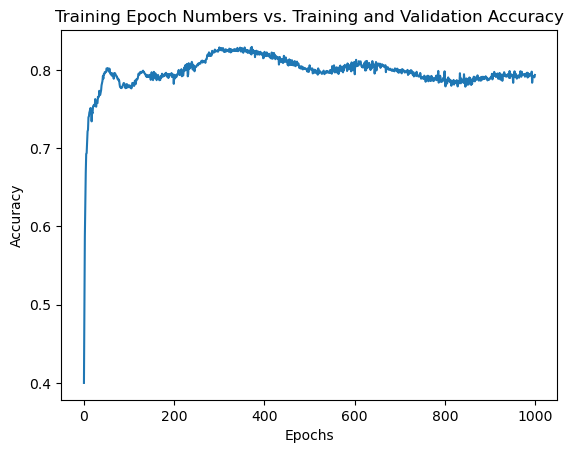

In [86]:
# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([784, 32, 16, 10], 0.001, 32, "tanh")
model.fit(trainX, trainY, 1000, 50)

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(testY, predictedY))
model.plot_loss()
model.plot_accuracy()

Running Neural Network with ReLu Activation Function

Epoch = 50 	 loss = 29434.735999517314
Epoch = 100 	 loss = 29078.647615295915
Epoch = 150 	 loss = 28722.30671846262
Epoch = 200 	 loss = 28109.19927334523
Epoch = 250 	 loss = 27648.84115274528
Epoch = 300 	 loss = 27282.73193142971
Epoch = 350 	 loss = 27105.049196095133
Epoch = 400 	 loss = 26965.326664418062
Epoch = 450 	 loss = 26875.179563395755
Epoch = 500 	 loss = 26787.89352075279
Epoch = 550 	 loss = 26716.62659223161
Epoch = 600 	 loss = 26604.73557395756
Epoch = 650 	 loss = 26557.906130775686
Epoch = 700 	 loss = 26516.347376541413
Epoch = 750 	 loss = 26450.28187379829
Epoch = 800 	 loss = 26442.282513694434
Epoch = 850 	 loss = 26387.858080533246
Epoch = 900 	 loss = 26360.581457689816
Epoch = 950 	 loss = 26266.746656868247
Epoch = 1000 	 loss = 26254.839537046366
Training set accuracy


/Users/erik/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/erik/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

           0       0.14      0.88      0.23      5923
           1       0.93      0.01      0.01      6742
           2       0.00      0.00      0.00      5958
           3       0.00      0.00      0.00      6131
           4       0.59      0.02      0.04      5842
           5       0.63      0.01      0.01      5421
           6       0.83      0.88      0.85      5918
           7       0.72      0.02      0.03      6265
           8       0.34      0.85      0.48      5851
           9       0.14      0.00      0.00      5949

    accuracy                           0.26     60000
   macro avg       0.43      0.27      0.17     60000
weighted avg       0.44      0.26      0.16     60000

Test set accuracy
              precision    recall  f1-score   support

           0       0.13      0.87      0.23       980
           1       0.88      0.01      0.01      1135
           2       0.00      0.00      0.00      1032
      

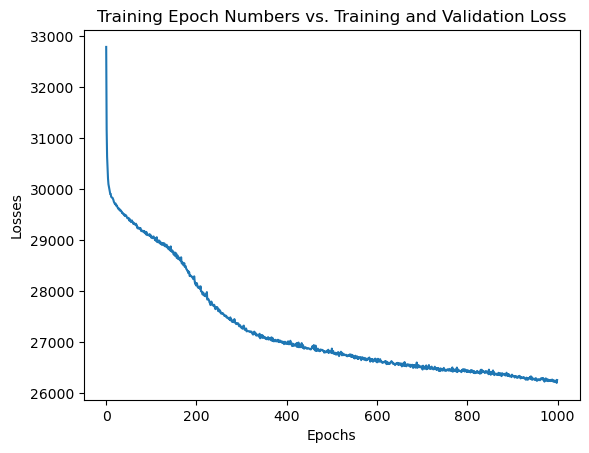

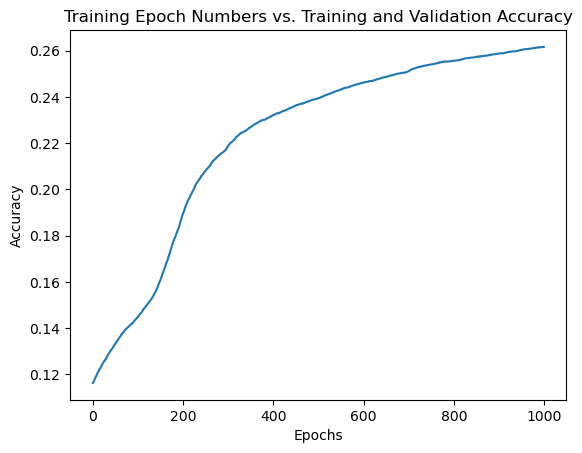

In [79]:
# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([784, 32, 16, 10], 0.0001, 32, "relu")
model.fit(trainX, trainY, 1000, 50)

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(testY, predictedY))
model.plot_loss()
model.plot_accuracy()

The sigmoid activation had a 98% accuracy on the training data and a 94% accuracy on the test data. For the tanh activation, the model possibly underfitted the training data with 79% accuracy while the test data had an 80% accuracy, which could have been due to rounding errors. The reLu function had the lowest accuracy with  26% accuracy for training and 25% for test. The sigmoid activiation had the best classification performance; however, I did not see any large differences in computational time between the various activiation functions.

## Question 5

The loss function is inversely related to the validation accuracy function, so as the loss of the neural network decreases, the
accuracy of the neural network increases. The sigmoid function had the greatest classification performance, and it seems that as the size of the neural network increases, the accuracy of the network slowly increases. So, a larger neural network should result in greater validation accuracy.

## Question 6

### Run network with three larger neural architectures

I will train the neural network with the sigmoid activation function with various increased hidden layers of nodes and number of nodes in each layer.

I increased the number of hidden layers with similar values to the current hidden layers.

Epoch = 50 	 loss = 2493.6391725207563
Epoch = 100 	 loss = 1750.5912870179102
Epoch = 150 	 loss = 1397.6311016125157
Epoch = 200 	 loss = 1217.8997157499675
Epoch = 250 	 loss = 1098.1686753627994
Epoch = 300 	 loss = 1022.7552799116256
Epoch = 350 	 loss = 965.4190847175819
Epoch = 400 	 loss = 930.1073403786515
Epoch = 450 	 loss = 894.346907239123
Epoch = 500 	 loss = 870.249639340363
Epoch = 550 	 loss = 858.2425191750137
Epoch = 600 	 loss = 837.8707247370527
Epoch = 650 	 loss = 822.8004997805145
Epoch = 700 	 loss = 814.617213051152
Epoch = 750 	 loss = 809.5029944634638
Epoch = 800 	 loss = 798.6083599122718
Epoch = 850 	 loss = 794.4994138384388
Epoch = 900 	 loss = 787.4042972732158
Epoch = 950 	 loss = 782.6536436574313
Epoch = 1000 	 loss = 831.090390082426
Training set accuracy
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.98      0.97

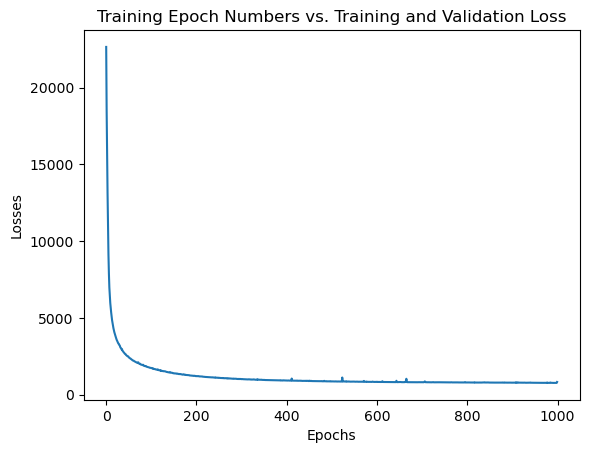

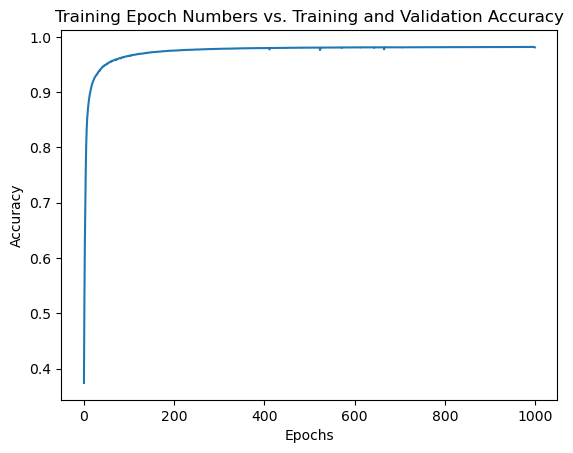

In [96]:
# fit the model to the training data
#increasing number of hidden layers
model = FeedforwardNeuralNetworkSGD([784, 32, 12, 18, 16, 10], 0.01, 32, "sigmoid")
model.fit(trainX, trainY, 1000, 50)

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(testY, predictedY))
model.plot_loss()
model.plot_accuracy()

I increased the number of neurons in the current hidden layers.

Epoch = 50 	 loss = 2352.8618256754307
Epoch = 100 	 loss = 1618.1097804667215
Epoch = 150 	 loss = 1264.035185297441
Epoch = 200 	 loss = 1050.3411158650683
Epoch = 250 	 loss = 914.9876924516444
Epoch = 300 	 loss = 820.3099080588701
Epoch = 350 	 loss = 750.4415528275645
Epoch = 400 	 loss = 694.5514008457343
Epoch = 450 	 loss = 652.8186059862924
Epoch = 500 	 loss = 619.1981505684113
Epoch = 550 	 loss = 589.186773684646
Epoch = 600 	 loss = 563.8876945342639
Epoch = 650 	 loss = 543.3073586154956
Epoch = 700 	 loss = 526.4866822293814
Epoch = 750 	 loss = 510.2926111536389
Epoch = 800 	 loss = 497.1830061123691
Epoch = 850 	 loss = 486.7768858269519
Epoch = 900 	 loss = 475.3795446390272
Epoch = 950 	 loss = 466.57337489224244
Epoch = 1000 	 loss = 457.16110155897866
Training set accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.99      0.

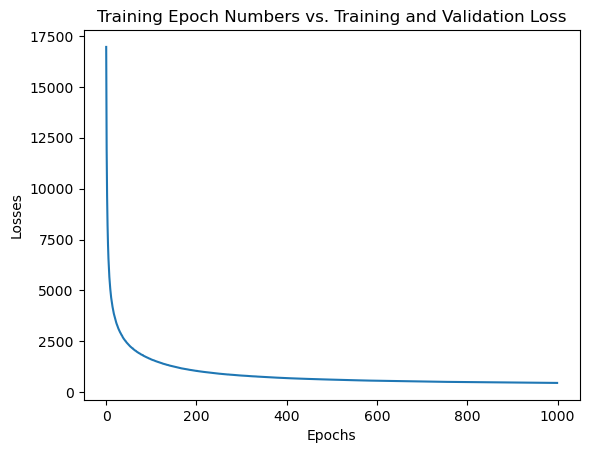

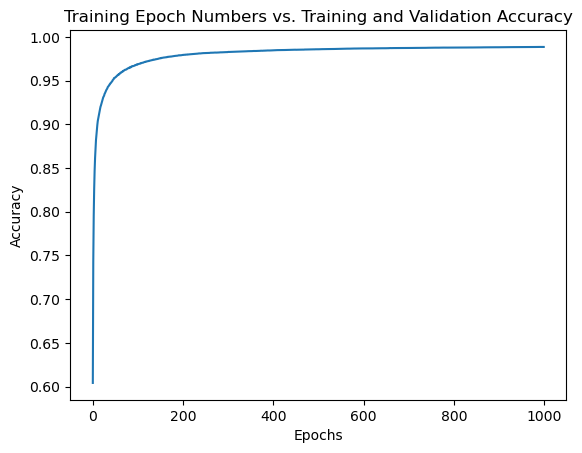

In [95]:
# fit the model to the training data
#increasing number of neurons in each hidden layer
model = FeedforwardNeuralNetworkSGD([784, 43, 25, 10], 0.01, 32, "sigmoid")
model.fit(trainX, trainY, 1000, 50)

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(testY, predictedY))
model.plot_loss()
model.plot_accuracy()

I increased the number of hidden layers using a larger number of neurons as well as increasing the current number.

Epoch = 50 	 loss = 2091.5062881597137
Epoch = 100 	 loss = 1392.1758696514498
Epoch = 150 	 loss = 1109.6722845651675
Epoch = 200 	 loss = 933.0328884605177
Epoch = 250 	 loss = 836.5641705158419
Epoch = 300 	 loss = 771.7416458816153
Epoch = 350 	 loss = 731.3810907277394
Epoch = 400 	 loss = 705.8638913207596
Epoch = 450 	 loss = 682.7829085755833
Epoch = 500 	 loss = 665.8381841265303
Epoch = 550 	 loss = 649.5602772990242
Epoch = 600 	 loss = 642.8385408516568
Epoch = 650 	 loss = 629.4881352294847
Epoch = 700 	 loss = 623.4002871218028
Epoch = 750 	 loss = 616.3041199790152
Epoch = 800 	 loss = 607.8387238517626
Epoch = 850 	 loss = 600.7663366656583
Epoch = 900 	 loss = 596.764225226936
Epoch = 950 	 loss = 593.8984500426187
Epoch = 1000 	 loss = 588.3669538438073
Training set accuracy
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.98      0.99

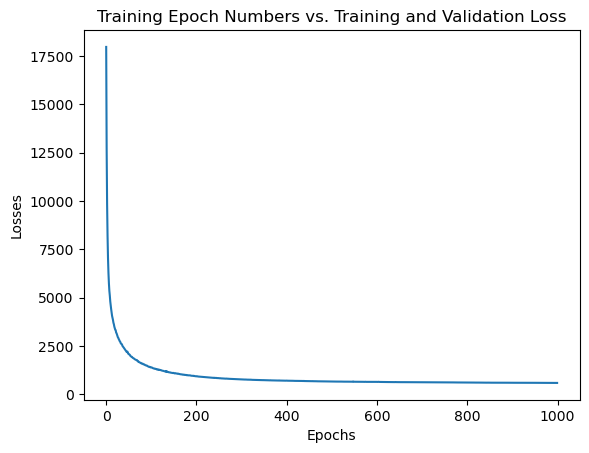

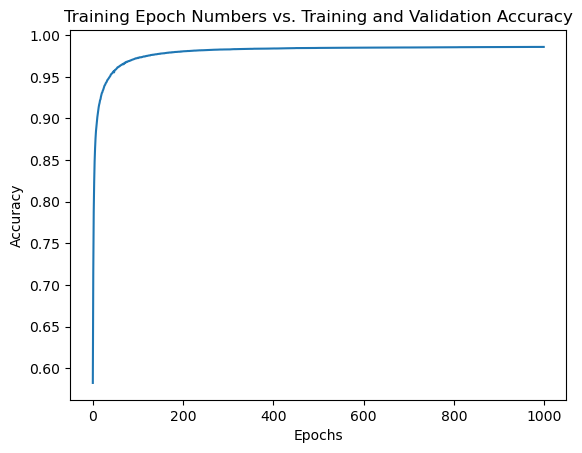

In [98]:
# fit the model to the training data
#increasing number of hidden layers and number of neurons in each layer
model = FeedforwardNeuralNetworkSGD([784, 40, 20, 45, 25, 10], 0.01, 32, "sigmoid")
model.fit(trainX, trainY, 1000, 50)

# print the classification performance
print("Training set accuracy")
print
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

print(classification_report(testY, predictedY))
model.plot_loss()
model.plot_accuracy()

Increasing the number of hidden layers kept the same training accuracy of 98%, but it slightly decreased the test accruacy from 94% to 93%. Increasing the number of neurons in each layer increased the training accuracy from 98% to 99% and increased the test accuracy from 94% to 95%. Increasing both the humber of hidden layers and the number of neurons in each layer increased the training data to 99% while keeping the test accuracy at 94%. Thus, creating a denser neural network can increase the accuracy of either the training data, the test data, or both, but at the expense of computation time.